In [145]:
import numpy as np
import random
import time
import pandas

from keras.callbacks import LambdaCallback

from keras import optimizers
from keras.layers import Activation, Input, LSTM, Dense, Dropout, BatchNormalization, GRU, Flatten, TimeDistributed
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

from pandas import read_csv
from socketIO_client import SocketIO, LoggingNamespace

from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import model_to_dot
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

In [146]:
# socket = SocketIO('localhost', 9876, LoggingNamespace)
# from MidiPlayer import MidiPlayer
# player = MidiPlayer()

In [147]:
dropout = 0.02
n_time_steps = 2
semi_redundancy_step = 3

In [148]:
corpus = read_csv('Audio/data/output.csv', header=1)
print(list(corpus))
print('corpus length:', len(corpus))

['0', ' 0.92', ' 18']
corpus length: 16


In [149]:
notes_index = corpus.values[:, 0]
length_index = corpus.values[:, 1]
print(note_index)
print(length_index)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

In [150]:
# notes = sorted(list(set(notes_index)))
lengths = sorted(list(set(length_index)))
notes = []
for i in range(0, 128):
    notes.append(i)
    
print('num_events:', len(notes))
# print(notes)
note_index = dict((c, i) for i, c in enumerate(notes))
index_note = dict((i, c) for i, c in enumerate(notes))

lengths_index = dict((c, i) for i, c in enumerate(lengths))
index_lengths = dict((i, c) for i, c in enumerate(lengths))
print(lengths_index)
print(index_lengths)

num_events: 128
{0.05: 0, 0.09: 1, 0.33: 2, 0.51: 3, 0.6: 4, 0.65: 5, 0.84: 6, 0.93: 7, 0.98: 8, 1.3: 9, 1.4: 10}
{0: 0.05, 1: 0.09, 2: 0.33, 3: 0.51, 4: 0.6, 5: 0.65, 6: 0.84, 7: 0.93, 8: 0.98, 9: 1.3, 10: 1.4}


In [151]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(length_index[:].reshape(-1,1))
# length_index = scaler.transform(length_index[:].reshape(-1,1))
# print(length_index[0:3])

In [152]:
length_phrases = []
next_length = []
note_phrases = []
next_note = []
for i in range(0, len(notes_index) - n_time_steps, semi_redundancy_step):
    note_phrases.append(notes_index[i: i + n_time_steps])
    length_phrases.append(length_index[i: i + n_time_steps])
    
    next_note.append(notes_index[i + n_time_steps])
    next_length.append(length_index[i + n_time_steps])
print('nb sequences:', len(note_phrases))
# for i in range(2):
#     print('______________')
#     print('note_x', note_phrases[i])
#     print('note_y', next_note[i])
#     print('length_x', length_phrases[i])
#     print('length_y', next_length[i])
print(length_phrases)
print(next_length)

nb sequences: 5
[array([0.65, 0.51]), array([1.4 , 0.05]), array([0.6 , 0.33]), array([0.09, 0.98]), array([1.3 , 0.51])]
[1.3, 0.93, 0.33, 1.3, 1.3]


In [153]:
print('Vectorization...')

note_x = np.zeros((len(note_phrases), n_time_steps, len(notes)), dtype=np.bool)
note_y = np.zeros((len(note_phrases), len(notes)), dtype=np.bool)

length_x = np.zeros((len(length_phrases), n_time_steps, len(lengths)), dtype=np.bool)
length_y = np.zeros((len(length_phrases), len(lengths)), dtype=np.bool)

for i, phrase in enumerate(note_phrases):
    for t, note in enumerate(phrase):
        print(i, t, note)
        note_x[i, t, note_index[note]] = 1
    note_y[i, note_index[next_note[i]]] = 1

for i, phrase in enumerate(length_phrases):
    for t, length in enumerate(phrase):
        print(i, t, length)
        length_x[i, t, lengths_index[length]] = 1
    length_y[i, lengths_index[next_length[i]]] = 1
    
# print('______________')
# print('length_x', length_x[0])
# print('length_y', length_y[0])
# print('note_x', note_x[0])
# print('note_y', note_y[0])

Vectorization...
0 0 58.0
0 1 57.0
1 0 52.0
1 1 61.0
2 0 0.0
2 1 50.0
3 0 53.0
3 1 52.0
4 0 55.0
4 1 52.0
0 0 0.65
0 1 0.51
1 0 1.4
1 1 0.05
2 0 0.6
2 1 0.33
3 0 0.09
3 1 0.98
4 0 1.3
4 1 0.51


In [154]:
print(note_x.shape)
print(length_x.shape)
print(note_y.shape)
print(length_y.shape)

(5, 2, 128)
(5, 2, 11)
(5, 128)
(5, 11)


In [172]:
lstm_size = 64

note_input = Input(name='note_input', shape=(n_time_steps, len(notes)))
length_input = Input(name='length_input', shape=(n_time_steps, len(lengths)))

# input_merge = concatenate([note_input, length_input])

# nn = LSTM(lstm_size, return_sequences=True)(input_merge)
# # nn = Dropout(dropout)(nn)
# nn = LSTM(lstm_size, return_sequences=True)(nn)

note_branch = LSTM(lstm_size, return_sequences=True)(note_input)
note_share = LSTM(int(lstm_size/4), return_sequences=True)(note_branch)

length_branch = LSTM(lstm_size, return_sequences=True)(length_input)
length_share = LSTM(int(lstm_size/4), return_sequences=True)(length_branch)

length_merge = concatenate([length_branch, note_share])
note_merge = concatenate([note_branch, length_share])

length_lstm = LSTM(lstm_size, return_sequences=False)(length_merge)
note_lstm = LSTM(lstm_size, return_sequences=False)(note_merge)
                    
output_notes = Dense(len(notes), activation='softmax', name='note_output')(note_lstm)
length_output = Dense(len(lengths), activation='softmax', name='length_output')(length_lstm)

optimizer = optimizers.RMSprop(lr=0.001)
model = Model(inputs=[note_input, length_input], outputs=[output_notes, length_output])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=optimizer)

In [173]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 2, 128)       0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 2, 11)        0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 2, 64)        49408       note_input[0][0]                 
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 2, 64)        19456       length_input[0][0]               
__________________________________________________________________________________________________
lstm_16 (L

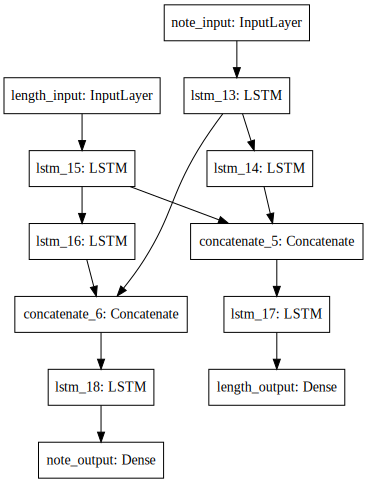

In [174]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [175]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [176]:
def midi_to_hertz(midi):
    if midi == 0:
        return 0
    g = 2**(1/12)
    return 440*g**(midi-69)

In [177]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    if epoch > 500 and epocch % 100 == 0:
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = 0
#         random.randint(0, len(notes_index) - n_time_steps - 1)
        for diversity in [1]:
            print('----- diversity:', diversity)

            generated_notes = []
            generated_length = []
            current_note_phrase = notes_index[start_index: start_index + n_time_steps]
            current_length_phrase = length_index[start_index: start_index + n_time_steps]
            generated_notes.extend(current_note_phrase)
            generated_length.extend(current_length_phrase)
    
#             print('----- Generating with seed: ')
#             print(current_note_phrase)
#             print(generated_length)

            n_generated = 50
            start_time = time.time()
            for i in range(n_generated):
                x_pred = np.zeros((1, n_time_steps, len(notes)))
                length_x_pred = np.zeros((1, n_time_steps, 1))

                for t, event in enumerate(current_note_phrase):
                    x_pred[0, t, note_index[event]] = 1.

                for t, event in enumerate(current_length_phrase):
                    length_x_pred[0, t, 0] = event

                pred = model.predict([x_pred, length_x_pred], verbose=0)
                note_pred = pred[0][0]
                length_pred = pred[1]
                
                length_prediction = scaler.inverse_transform(length_pred)[0]
                note_index_from_sample = sample(note_pred, diversity)
                note_prediction = index_note[note_index_from_sample]
                
#                 print(note_prediction)
#                 print(length_prediction)
                
                generated_notes.append(note_prediction)
                generated_length.append(length_prediction)
                
                current_note_phrase = np.append(current_note_phrase[1:], note_prediction)
                current_length_phrase = np.append(current_length_phrase[1:], length_pred)
                
                end_time = time.time()
#             print(generated_notes)
            
#             print('average_prediction_speed:', (end_time-start_time)/n_generated)
            generated_length_scaled = list(scaler.inverse_transform(generated_length).reshape(1,-1)[0])
            counter = 0
            for i in range(len(generated_notes)):
                note = generated_notes[i]
                length = generated_length_scaled[i]
                freq = midi_to_hertz(note)
                print(freq, '|', length)
                if i == n_time_steps:
                    print('generated')
                    socket.emit('freq_change', {'freq': 4000, 'vol': 100})
                    time.sleep(0.03)
                
                socket.emit('freq_change', {'freq': freq, 'vol': 100})
                time.sleep(length * .5)


            socket.emit('freq_change', {'freq': 0, 'vol': 100})

In [178]:
# print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit([note_x, length_x], [note_y, length_y],
          batch_size=256,
          epochs=1000,
#           callbacks=[print_callback]
        )

Epoch 1/1000
5/5 [==============================] - 2s 447ms/step - loss: 7.2460 - note_output_loss: 4.8508 - length_output_loss: 2.3952
Epoch 2/1000
5/5 [==============================] - 0s 3ms/step - loss: 7.2024 - note_output_loss: 4.8326 - length_output_loss: 2.3699
Epoch 3/1000
5/5 [==============================] - 0s 3ms/step - loss: 7.1678 - note_output_loss: 4.8183 - length_output_loss: 2.3495
Epoch 4/1000
5/5 [==============================] - 0s 4ms/step - loss: 7.1346 - note_output_loss: 4.8046 - length_output_loss: 2.3300
Epoch 5/1000
5/5 [==============================] - 0s 4ms/step - loss: 7.1013 - note_output_loss: 4.7910 - length_output_loss: 2.3103
Epoch 6/1000
5/5 [==============================] - 0s 4ms/step - loss: 7.0661 - note_output_loss: 4.7767 - length_output_loss: 2.2894
Epoch 7/1000
5/5 [==============================] - 0s 5ms/step - loss: 7.0288 - note_output_loss: 4.7614 - length_output_loss: 2.2674
Epoch 8/1000
5/5 [==============================] - 0

5/5 [==============================] - 0s 4ms/step - loss: 1.8782 - note_output_loss: 1.5420 - length_output_loss: 0.3361
Epoch 62/1000
5/5 [==============================] - 0s 3ms/step - loss: 1.8499 - note_output_loss: 1.5340 - length_output_loss: 0.3159
Epoch 63/1000
5/5 [==============================] - 0s 3ms/step - loss: 1.8221 - note_output_loss: 1.5258 - length_output_loss: 0.2963
Epoch 64/1000
5/5 [==============================] - 0s 5ms/step - loss: 1.7946 - note_output_loss: 1.5175 - length_output_loss: 0.2771
Epoch 65/1000
5/5 [==============================] - 0s 4ms/step - loss: 1.7675 - note_output_loss: 1.5089 - length_output_loss: 0.2585
Epoch 66/1000
5/5 [==============================] - 0s 3ms/step - loss: 1.7408 - note_output_loss: 1.5002 - length_output_loss: 0.2406
Epoch 67/1000
5/5 [==============================] - 0s 4ms/step - loss: 1.7144 - note_output_loss: 1.4910 - length_output_loss: 0.2234
Epoch 68/1000
5/5 [==============================] - 0s 5ms/st

Epoch 122/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.3054 - note_output_loss: 0.3027 - length_output_loss: 0.0028
Epoch 123/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.2886 - note_output_loss: 0.2860 - length_output_loss: 0.0026
Epoch 124/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.2724 - note_output_loss: 0.2700 - length_output_loss: 0.0024
Epoch 125/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.2571 - note_output_loss: 0.2548 - length_output_loss: 0.0023
Epoch 126/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.2424 - note_output_loss: 0.2403 - length_output_loss: 0.0021
Epoch 127/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.2284 - note_output_loss: 0.2264 - length_output_loss: 0.0020
Epoch 128/1000
5/5 [==============================] - 0s 5ms/step - loss: 0.2151 - note_output_loss: 0.2132 - length_output_loss: 0.0019
Epoch 129/1000
5/5 [=====================

Epoch 181/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.0082 - note_output_loss: 0.0080 - length_output_loss: 1.2064e-04
Epoch 182/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.0077 - note_output_loss: 0.0076 - length_output_loss: 1.1515e-04
Epoch 183/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.0073 - note_output_loss: 0.0072 - length_output_loss: 1.0991e-04
Epoch 184/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.0069 - note_output_loss: 0.0068 - length_output_loss: 1.0493e-04
Epoch 185/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.0065 - note_output_loss: 0.0064 - length_output_loss: 1.0023e-04
Epoch 186/1000
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - note_output_loss: 0.0061 - length_output_loss: 9.5778e-05
Epoch 187/1000
5/5 [==============================] - 0s 4ms/step - loss: 0.0059 - note_output_loss: 0.0058 - length_output_loss: 9.1475e-05
Epoch 188/100

Epoch 239/1000
5/5 [==============================] - 0s 3ms/step - loss: 4.6594e-04 - note_output_loss: 4.5581e-04 - length_output_loss: 1.0133e-05
Epoch 240/1000
5/5 [==============================] - 0s 5ms/step - loss: 4.4623e-04 - note_output_loss: 4.3646e-04 - length_output_loss: 9.7633e-06
Epoch 241/1000
5/5 [==============================] - 0s 4ms/step - loss: 4.2724e-04 - note_output_loss: 4.1786e-04 - length_output_loss: 9.3818e-06
Epoch 242/1000
5/5 [==============================] - 0s 3ms/step - loss: 4.0916e-04 - note_output_loss: 4.0012e-04 - length_output_loss: 9.0361e-06
Epoch 243/1000
5/5 [==============================] - 0s 3ms/step - loss: 3.9190e-04 - note_output_loss: 3.8324e-04 - length_output_loss: 8.6666e-06
Epoch 244/1000
5/5 [==============================] - 0s 4ms/step - loss: 3.7547e-04 - note_output_loss: 3.6709e-04 - length_output_loss: 8.3805e-06
Epoch 245/1000
5/5 [==============================] - 0s 6ms/step - loss: 3.5971e-04 - note_output_loss: 3

Epoch 294/1000
5/5 [==============================] - 0s 5ms/step - loss: 4.7637e-05 - note_output_loss: 4.6302e-05 - length_output_loss: 1.3351e-06
Epoch 295/1000
5/5 [==============================] - 0s 3ms/step - loss: 4.5813e-05 - note_output_loss: 4.4538e-05 - length_output_loss: 1.2755e-06
Epoch 296/1000
5/5 [==============================] - 0s 3ms/step - loss: 4.4061e-05 - note_output_loss: 4.2821e-05 - length_output_loss: 1.2398e-06
Epoch 297/1000
5/5 [==============================] - 0s 4ms/step - loss: 4.2296e-05 - note_output_loss: 4.1104e-05 - length_output_loss: 1.1921e-06
Epoch 298/1000
5/5 [==============================] - 0s 5ms/step - loss: 4.0735e-05 - note_output_loss: 3.9554e-05 - length_output_loss: 1.1802e-06
Epoch 299/1000
5/5 [==============================] - 0s 5ms/step - loss: 3.9125e-05 - note_output_loss: 3.8005e-05 - length_output_loss: 1.1206e-06
Epoch 300/1000
5/5 [==============================] - 0s 5ms/step - loss: 3.7552e-05 - note_output_loss: 3

Epoch 349/1000
5/5 [==============================] - 0s 5ms/step - loss: 6.0678e-06 - note_output_loss: 5.8055e-06 - length_output_loss: 2.6226e-07
Epoch 350/1000
5/5 [==============================] - 0s 4ms/step - loss: 5.8293e-06 - note_output_loss: 5.5671e-06 - length_output_loss: 2.6226e-07
Epoch 351/1000
5/5 [==============================] - 0s 3ms/step - loss: 5.6625e-06 - note_output_loss: 5.4002e-06 - length_output_loss: 2.6226e-07
Epoch 352/1000
5/5 [==============================] - 0s 3ms/step - loss: 5.4360e-06 - note_output_loss: 5.1975e-06 - length_output_loss: 2.3842e-07
Epoch 353/1000
5/5 [==============================] - 0s 3ms/step - loss: 5.2452e-06 - note_output_loss: 5.0306e-06 - length_output_loss: 2.1458e-07
Epoch 354/1000
5/5 [==============================] - 0s 5ms/step - loss: 5.0902e-06 - note_output_loss: 4.8757e-06 - length_output_loss: 2.1458e-07
Epoch 355/1000
5/5 [==============================] - 0s 4ms/step - loss: 4.9234e-06 - note_output_loss: 4

Epoch 404/1000
5/5 [==============================] - 0s 4ms/step - loss: 1.0967e-06 - note_output_loss: 9.7752e-07 - length_output_loss: 1.1921e-07
Epoch 405/1000
5/5 [==============================] - 0s 4ms/step - loss: 1.0848e-06 - note_output_loss: 9.6560e-07 - length_output_loss: 1.1921e-07
Epoch 406/1000
5/5 [==============================] - 0s 3ms/step - loss: 1.0490e-06 - note_output_loss: 9.2983e-07 - length_output_loss: 1.1921e-07
Epoch 407/1000
5/5 [==============================] - 0s 3ms/step - loss: 1.0014e-06 - note_output_loss: 8.8215e-07 - length_output_loss: 1.1921e-07
Epoch 408/1000
5/5 [==============================] - 0s 5ms/step - loss: 9.8944e-07 - note_output_loss: 8.7023e-07 - length_output_loss: 1.1921e-07
Epoch 409/1000
5/5 [==============================] - 0s 4ms/step - loss: 9.8944e-07 - note_output_loss: 8.7023e-07 - length_output_loss: 1.1921e-07
Epoch 410/1000
5/5 [==============================] - 0s 4ms/step - loss: 9.5367e-07 - note_output_loss: 8

Epoch 459/1000
5/5 [==============================] - 0s 4ms/step - loss: 3.6955e-07 - note_output_loss: 2.5034e-07 - length_output_loss: 1.1921e-07
Epoch 460/1000
5/5 [==============================] - 0s 3ms/step - loss: 3.6955e-07 - note_output_loss: 2.5034e-07 - length_output_loss: 1.1921e-07
Epoch 461/1000
5/5 [==============================] - 0s 3ms/step - loss: 3.5763e-07 - note_output_loss: 2.3842e-07 - length_output_loss: 1.1921e-07
Epoch 462/1000
5/5 [==============================] - 0s 4ms/step - loss: 3.5763e-07 - note_output_loss: 2.3842e-07 - length_output_loss: 1.1921e-07
Epoch 463/1000
5/5 [==============================] - 0s 4ms/step - loss: 3.5763e-07 - note_output_loss: 2.3842e-07 - length_output_loss: 1.1921e-07
Epoch 464/1000
5/5 [==============================] - 0s 4ms/step - loss: 3.5763e-07 - note_output_loss: 2.3842e-07 - length_output_loss: 1.1921e-07
Epoch 465/1000
5/5 [==============================] - 0s 4ms/step - loss: 3.5763e-07 - note_output_loss: 2

Epoch 514/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 515/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 516/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 517/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 518/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.6226e-07 - note_output_loss: 1.4305e-07 - length_output_loss: 1.1921e-07
Epoch 519/1000
5/5 [==============================] - 0s 5ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 520/1000
5/5 [==============================] - 0s 6ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 569/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 570/1000
5/5 [==============================] - 0s 8ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 571/1000
5/5 [==============================] - 0s 6ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 572/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 573/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 574/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 575/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 624/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 625/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 626/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 627/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 628/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 629/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 630/1000
5/5 [==============================] - 0s 5ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 679/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 680/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 681/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 682/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 683/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 684/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 685/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 734/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 735/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 736/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 737/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 738/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 739/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 740/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 789/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 790/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 791/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 792/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 793/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 794/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 795/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 844/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 845/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 846/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 847/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 848/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 849/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 850/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 899/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 900/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 901/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 902/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 903/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 904/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 905/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1

Epoch 954/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 955/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 956/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 957/1000
5/5 [==============================] - 0s 3ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 958/1000
5/5 [==============================] - 0s 5ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 959/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1.1921e-07 - length_output_loss: 1.1921e-07
Epoch 960/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.3842e-07 - note_output_loss: 1

In [ ]:
joblib.dump(scaler, 'scaler.pkl')
print('Saved scaler to disk.')